In [ ]:
!pip install torchmetrics

In [1]:
import csv
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
def eval_model(batch_no, loaded_model, dataset):
    rows = 4
    cols = 8
    start = rows * cols * batch_no
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i in range(rows * cols):
        idx = i + start
        j = i // cols
        k = i % cols
        axes[j][k].imshow(dataset.test_data[idx], cmap="gray")

        axes[j][k].tick_params(
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False,
        )
        with torch.no_grad():
            normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[idx][0]))
            prediction = loaded_model(normalized.unsqueeze(0)).argmax()
        pred_num = prediction.item()
        labl_num = dataset.targets[idx].item()
        title = f"{pred_num}-{labl_num}"
        border_color = "green" if pred_num == labl_num else "red"
        plt.setp(axes[j][k].spines.values(), lw=5, color=border_color, alpha=0.9)
        axes[j][k].set_title(title)


# Train model

## Train model with pytorch

In [7]:
from trainloop import train_loop_torch
from trainloop import build_resnet18
from trainloop import load_model_torch
from trainloop import build_data_loader_torch
from trainloop import report_metrics_torch
from trainloop import save_checkpoint_and_metrics_torch

### Launch the training loop

In [4]:
timestamp = datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H-%M-%S")
local_path = f"/tmp/ray/torch_{timestamp}"
train_loop_torch(num_epochs=4, local_path=local_path)

{'loss': 0.2948448359966278, 'epoch': 0, 'accuracy': 0.7934361696243286}
{'loss': 0.09106287360191345, 'epoch': 1, 'accuracy': 0.9477664232254028}
{'loss': 0.05585106834769249, 'epoch': 2, 'accuracy': 0.9681657552719116}
{'loss': 0.07025408744812012, 'epoch': 3, 'accuracy': 0.9799846410751343}


### Evaluate Trained Model

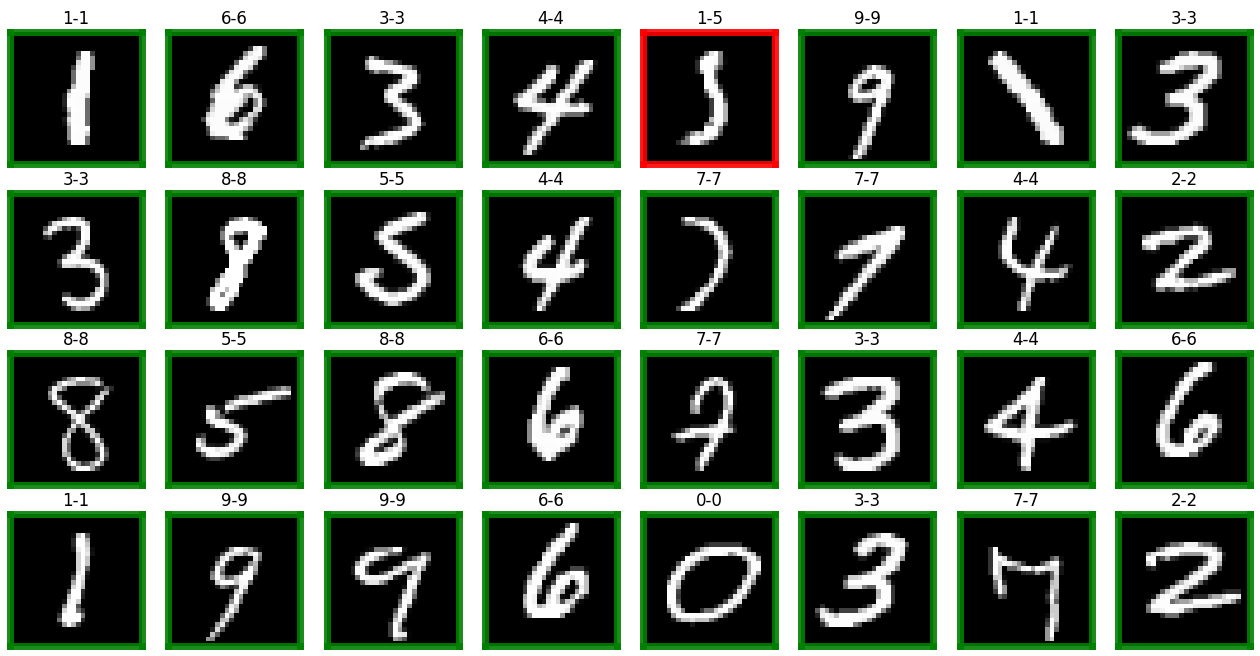

In [32]:
ckpt_dir = "/tmp/ray/torch_2025-03-05_23-28-05"
model_path = os.path.join(ckpt_dir, "model.pt")
loaded_model = build_resnet18()
state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()
dataset = MNIST(root="./data", train=True, download=True)

batch_no = 4

eval_model(batch_no, loaded_model, dataset)

## Train model with ray train

In [3]:
from trainloop import train_loop_ray_train
from trainloop import load_model_ray_train
from trainloop import build_data_loader_ray_train
from trainloop import report_metrics_ray_train
from trainloop import save_checkpoint_and_metrics_ray_train

In [4]:
from ray.train import RunConfig, ScalingConfig
from ray.train.torch import TorchTrainer

storage_path = "/tmp/ray_train"
run_config = RunConfig(storage_path=storage_path, name="distributed-mnist-resnet18")
scaling_config = ScalingConfig(num_workers=2, use_gpu=torch.cuda.is_available())

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 6, "global_batch_size": 128},
)

result = trainer.fit()

/Users/justin/miniconda3/envs/ai-computing/lib/python3.11/site-packages/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-08 17:06:37,015	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2025-03-08 17:06:38,759	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `<FrameworkTrainer>(...)`.
2025-03-08 17:06:38,762	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/

== Status ==
Current time: 2025-03-08 17:06:38 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-03-08 17:06:43 (running for 00:00:05.22)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)




(RayTrainWorker pid=67596) Setting up process group for: env:// [rank=0, world_size=2]
(TorchTrainer pid=67595) Started distributed worker processes: 
(TorchTrainer pid=67595) - (node_id=d97528dc33d1bfb908ec86779d3d329f5382f10b8a20009e9fa7c626, ip=127.0.0.1, pid=67596) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=67595) - (node_id=d97528dc33d1bfb908ec86779d3d329f5382f10b8a20009e9fa7c626, ip=127.0.0.1, pid=67597) world_rank=1, local_rank=1, node_rank=0


== Status ==
Current time: 2025-03-08 17:06:49 (running for 00:00:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


(RayTrainWorker pid=67596) ['T_destination', '__abstractmethods__', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_active_ddp_module', '_apply', '_assign_modules_buffers', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_build_debug_param_to_name_mapping', '_buil

(RayTrainWorker pid=67596) Moving model to device: cpu
(RayTrainWorker pid=67596) Wrapping provided model in DistributedDataParallel.


== Status ==
Current time: 2025-03-08 17:06:54 (running for 00:00:15.30)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=67596) /Users/justin/miniconda3/envs/ai-computing/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
(RayTrainWorker pid=67596)   warnings.warn(*args, **kwargs)


== Status ==
Current time: 2025-03-08 17:06:59 (running for 00:00:20.31)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:07:04 (running for 00:00:25.32)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:07:09 (running for 00:00:30.32)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67597) /Users/justin/miniconda3/envs/ai-computing/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
(RayTrainWorker pid=67597)   warnings.warn(*args, **kwargs)


== Status ==
Current time: 2025-03-08 17:08:19 (running for 00:01:40.81)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:08:24 (running for 00:01:45.82)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:08:29 (running for 00:01:50.83)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000000)


== Status ==
Current time: 2025-03-08 17:12:50 (running for 00:06:12.12)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:12:55 (running for 00:06:17.13)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:13:00 (running for 00:06:22.13)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000001)


== Status ==
Current time: 2025-03-08 17:18:48 (running for 00:12:09.29)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:18:53 (running for 00:12:14.29)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:18:58 (running for 00:12:19.40)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000002)


== Status ==
Current time: 2025-03-08 17:24:50 (running for 00:18:11.32)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:24:55 (running for 00:18:16.33)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:25:00 (running for 00:18:21.43)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000003)


== Status ==
Current time: 2025-03-08 17:31:07 (running for 00:24:29.12)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:31:12 (running for 00:24:34.23)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:31:18 (running for 00:24:39.23)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000004)


== Status ==
Current time: 2025-03-08 17:37:25 (running for 00:30:46.83)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:37:30 (running for 00:30:51.84)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2025-03-08 17:37:35 (running for 00:30:56.85)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Curren

(RayTrainWorker pid=67596) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_train/distributed-mnist-resnet18/TorchTrainer_bc00f_00000_0_2025-03-08_17-06-38/checkpoint_000005)
2025-03-08 17:43:35,142	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/tmp/ray_train/distributed-mnist-resnet18' in 0.0055s.
2025-03-08 17:43:35,144	INFO tune.py:1041 -- Total run time: 2216.38 seconds (2216.36 seconds for the tuning loop).


== Status ==
Current time: 2025-03-08 17:43:35 (running for 00:36:56.37)
Using FIFO scheduling algorithm.
Logical resource usage: 3.0/12 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2025-03-08_17-06-33_583687_67572/artifacts/2025-03-08_17-06-38/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [36]:
result.metrics_dataframe

,loss,accuracy,auroc,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/num_epochs,config/train_loop_config/global_batch_size
0,0.305836,0.804270,0.976276,1741400777,checkpoint_000000,True,False,1,d7293_00000,2025-03-08_15-26-17,366.879803,366.879803,66832,MacBookPro,127.0.0.1,366.879803,1,6,128
1,0.070980,0.944812,0.989964,1741401131,checkpoint_000001,True,False,2,d7293_00000,2025-03-08_15-32-11,354.591221,721.471024,66832,MacBookPro,127.0.0.1,721.471024,2,6,128
2,0.163146,0.966246,0.994096,1741401502,checkpoint_000002,True,False,3,d7293_00000,2025-03-08_15-38-22,370.503281,1091.974305,66832,MacBookPro,127.0.0.1,1091.974305,3,6,128
3,0.044282,0.976512,0.996063,1741401931,checkpoint_000003,True,False,4,d7293_00000,2025-03-08_15-45-31,428.779749,1520.754054,66832,MacBookPro,127.0.0.1,1520.754054,4,6,128
4,0.071155,0.983507,0.997175,1741402341,checkpoint_000004,True,False,5,d7293_00000,2025-03-08_15-52-21,410.083867,1930.837921,66832,MacBookPro,127.0.0.1,1930.837921,5,6,128
5,0.071465,0.989032,0.997887,1741402735,checkpoint_000005,True,False,6,d7293_00000,2025-03-08_15-58-55,393.841035,2324.678956,66832,MacBookPro,127.0.0.1,2324.678956,6,6,128


### Evaluation trained model

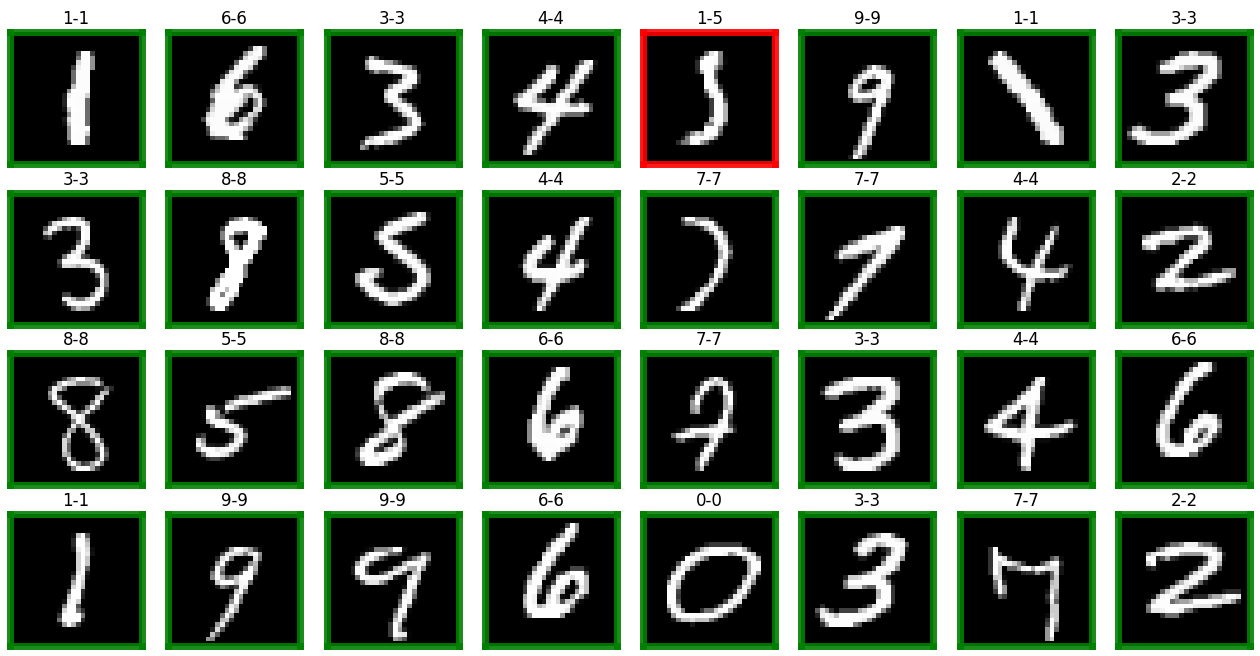

In [35]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model.load_state_dict(state_dict)
    loaded_model.eval()
dataset = MNIST(root="./data", train=True, download=True)

batch_no = 4

eval_model(batch_no, loaded_model, dataset)

                             

In [37]:
torch.cuda.is_available()

False